In [0]:
import torch

In [0]:
torch.cuda.is_available()

True

In [0]:
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

In [0]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: ignored

In [0]:
import os
import numpy as np

data_dir = '/content/drive/My Drive/flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [0]:
transform = transforms.Compose([transforms.RandomResizedCrop(224),
                                transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform = transform)
test_data = datasets.ImageFolder(test_dir, transform = transform)

print (len(train_data))
print (len(test_data))

3139
540


In [0]:
batch_size = 20
num_workers = 0

train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers, shuffle = True)

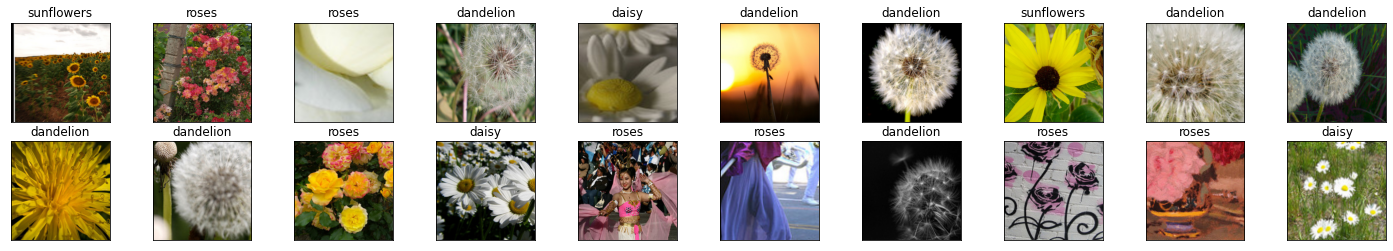

In [0]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx + 1, xticks = [], yticks=[])
  plt.imshow(np.transpose(images[idx], (1, 2, 0)))
  ax.set_title(classes[labels[idx]])

In [0]:
vgg16 = models.vgg16(pretrained = True)
print (vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [0]:
print(vgg16.classifier[6].in_features)
print(vgg16.classifier[6].out_features)

4096
1000


In [0]:
for param in vgg16.features.parameters():
  param.requires_grad = False

In [0]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(vgg16.classifier.parameters(), lr = 0.001)

In [0]:
n_inputs = vgg16.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))

vgg16.classifier[6] = last_layer

vgg16.cuda()
print (vgg16.classifier[6].out_features)

5


In [0]:
n_epochs = 2
for epoch in range(1, n_epochs+1):
  train_loss = 0.1
  for batch_i, (data, target) in enumerate(train_loader):
    data, target = data.cuda(), target.cuda()
    optimizer.zero_grad()
    output = vgg16(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    train_loss += loss.item()
    if batch_i%20 == 19:
      print('Epoch %d, Batch %d, loss: %.16f' %(epoch, batch_i + 1, train_loss/20))
      train_loss = 0.0

Epoch 1, Batch 20, loss: 1.6992613482475281
Epoch 1, Batch 40, loss: 1.6481127142906189
Epoch 1, Batch 60, loss: 1.6106589615345002
Epoch 1, Batch 80, loss: 1.5629439115524293
Epoch 1, Batch 100, loss: 1.5677796542644500
Epoch 1, Batch 120, loss: 1.5147358298301696
Epoch 1, Batch 140, loss: 1.4853031992912293
Epoch 2, Batch 20, loss: 1.4499302732944490
Epoch 2, Batch 40, loss: 1.4191486418247223
Epoch 2, Batch 60, loss: 1.3693028271198273
Epoch 2, Batch 80, loss: 1.3957323908805848
Epoch 2, Batch 100, loss: 1.3805731356143951
Epoch 2, Batch 120, loss: 1.3279499471187592
Epoch 2, Batch 140, loss: 1.3487751185894012


In [0]:
test_loss = 0.0
class_correct = list(0 for i in range(5))
class_total = list(0 for i in range(5))

vgg16.eval()

for data, target in test_loader:
  data, target = data.cuda(), target.cuda()
  output = vgg16(data)
  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.cpu().numpy())
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print ('Test Loss {:.6f}'.format(test_loss))


Test Loss 1.259423


In [0]:
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Accuracy of daisy: 52% (48/92)
Test Accuracy of dandelion: 93% (124/132)
Test Accuracy of roses: 25% (23/91)
Test Accuracy of sunflowers: 54% (55/101)
Test Accuracy of tulips: 71% (89/124)

Test Accuracy (Overall): 62% (339/540)
